In [1]:
import numpy as np
import vtk
import matplotlib.pyplot as plt
import os
import netCDF4 as nc
from vtk import vtkUnstructuredGridReader
from vtk import vtkXMLUnstructuredGridReader
from vtk.util import numpy_support as VN
from vtk.util.numpy_support import vtk_to_numpy
from scipy.spatial import KDTree
import pygmt
import pandas
os.chdir("../postprocessing_scripts/")
import MORVEL
os.chdir("../main_figures/")

In [2]:
def cartesian_to_spherical(x, y, z):
    """
    Takes an x, y, z and converts it to spherical coordinates. Returns r, theta, phi
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = 90 - np.rad2deg( np.arccos( z / (np.sqrt(x**2 + y**2 + z**2)) ) )
    phi =  np.sign(y) * np.rad2deg(np.arccos( x / np.sqrt(x**2 + y**2) ))
    phi[np.where(phi < 0)] = phi[np.where(phi < 0)] + 360
    phi[np.where(phi == 0)] = 180
    
    return r, phi, theta

def spherical_to_global_cartesian(r, phi, theta):
    """
    Takes spherical coordinates r, theta, and phi and converts to Cartesian coordinates.
    Returns x, y, z
    """
    x = r * np.sin(np.deg2rad(90 - theta)) * np.cos(np.deg2rad(phi))
    y = r * np.sin(np.deg2rad(90 - theta)) * np.sin(np.deg2rad(phi))
    z = r * np.cos(np.deg2rad(90 - theta))
    
    return x, y, z

In [3]:
# Load in the regional dataset from Donna
data_dir_path = "../data/" 
AUS_eastprov = np.loadtxt(fname=data_dir_path + "DEP_zealith2/AUS_lith75.xyd", comments='>')
AUS_MB = np.loadtxt(fname=data_dir_path + "DEP_zealith2/AUS_lith150.xyd", comments='>')
AUS_westprov = np.loadtxt(fname=data_dir_path + "DEP_zealith2/AUS_lith100.xyd", comments='>')
AUS_TVZ = np.loadtxt(fname=data_dir_path + "DEP_zealith2/AUS_lith50.xyd", comments='>')

trench = np.loadtxt(fname=data_dir_path + "trench_contour.csv", delimiter=',')[0:270]

PAC_eastprov = np.loadtxt(fname=data_dir_path + "DEP_zealith2/PAC_lith75.xyd", comments='>')
PAC_MB = np.loadtxt(fname=data_dir_path + "DEP_zealith2/PAC_lith150.xyd", comments='>')
PAC_westprov = np.loadtxt(fname=data_dir_path + "DEP_zealith2/PAC_lith100.xyd", comments='>')
HIK_plateau = np.loadtxt(fname=data_dir_path + "Hikurangi_Plateau_wgs84.csv", delimiter=',', skiprows=1)

HIK_plateau = np.delete(HIK_plateau, [83, -1], axis=0)
for i in range(len(HIK_plateau)):
    if HIK_plateau[:, 0][i] < 0:
        HIK_plateau[:, 0][i] += 360
        
slab2_cont = np.loadtxt(fname=data_dir_path + "slab2_tonga.in", delimiter='\t', comments='>', dtype=float)
slab2_depth = np.loadtxt(fname=data_dir_path + "combined_slab2.txt")
slab2_contours = np.array(sorted(slab2_cont, key=lambda x: x[1], reverse=True))

puysegur_trench = np.loadtxt(fname=data_dir_path + "puy_trench.csv", delimiter=',')[0:55]
supplemental_file = np.loadtxt(fname=data_dir_path + "ker_slab2_sup_02.24.18.csv", delimiter=',', skiprows=1)

anisotropy_data = np.loadtxt(fname=data_dir_path + "modified_anisotropy_data.txt", comments='#')

anisotropy_latitude = anisotropy_data[:, 0]
anisotropy_longitude = anisotropy_data[:, 1]

min_max_LPO_lon = [anisotropy_longitude[np.where(anisotropy_latitude == np.min(anisotropy_latitude))][0], \
                   np.max(anisotropy_longitude), \
                   anisotropy_longitude[np.where(anisotropy_latitude == np.max(anisotropy_latitude))][0], \
                   np.min(anisotropy_longitude), \
                   anisotropy_longitude[np.where(anisotropy_latitude == np.min(anisotropy_latitude))][0]]
min_max_LPO_lat = [np.min(anisotropy_latitude), \
                   anisotropy_latitude[np.where(anisotropy_longitude == np.min(anisotropy_longitude))][0], \
                   np.max(anisotropy_latitude), \
                   anisotropy_latitude[np.where(anisotropy_longitude == np.max(anisotropy_longitude))][0], \
                   np.min(anisotropy_latitude)]

profile_directory = "../slab2_worldbuilder_generation/profiles_for_worldbuilder/geographic/"
ASPECT_trench_lon = np.empty(0)
ASPECT_trench_lat = np.empty(0)
for file in np.sort(os.listdir(profile_directory)):
    profile_file = np.loadtxt(fname=profile_directory + file)
    trench_ind = np.where(profile_file[:, 0] == np.max(profile_file[:, 0]))
    ASPECT_trench_lon = np.concatenate( (ASPECT_trench_lon, np.array([profile_file[:, 0][trench_ind][0]])))
    ASPECT_trench_lat = np.concatenate( (ASPECT_trench_lat, np.array([profile_file[:, 1][trench_ind][0]])))

earthquakes = np.loadtxt(fname=data_dir_path + "earthquake_updated.csv", \
                         skiprows=1, usecols=[1, 2, 3, 4], delimiter=',')
volcanoes = np.loadtxt(fname=data_dir_path + "volcanoes.txt")
Alpine_Fault = np.loadtxt(fname=data_dir_path + "Alpine_Fault_extension.txt")

In [4]:
sol_dir_path = "../ASPECT_models/5e20_10kmweak_dry/solution/"

t_step = 0

ASPECT_positions = np.empty(0)
litho_total = np.empty(0)
crust_total = np.empty(0)

for soln in solutions:
    if soln[-4:-1] == '.vt' and soln[9:14] == str(t_step).zfill(5):
        
        file_path = os.path.join(sol_dir_path, soln)
        reader = vtkXMLUnstructuredGridReader()
        reader.SetFileName(file_path)
        reader.Update()
        data = reader.GetOutput()
        points = data.GetPoints()
        x = vtk_to_numpy(points.GetData())
        litho = vtk_to_numpy(data.GetPointData().GetArray('Base_Subducting'))
        crust = vtk_to_numpy(data.GetPointData().GetArray('Crust'))

        if len(ASPECT_positions) == 0:
            ASPECT_positions = x
        else:
            ASPECT_positions = np.concatenate( (ASPECT_positions, x) )
        litho_total = np.concatenate( (litho_total, litho) )
        crust_total = np.concatenate( (crust_total, crust) )

slab_indices = np.where( (litho_total >= 0.5) | (crust_total >= 0.5) )
slab_x = ASPECT_positions[:, 0][slab_indices]
slab_y = ASPECT_positions[:, 1][slab_indices]
slab_z = ASPECT_positions[:, 2][slab_indices]
ASPECT_slab_r, ASPECT_slab_phi, ASPECT_slab_theta = cartesian_to_spherical(slab_x, slab_y, slab_z)

tree_unstructured = KDTree(np.c_[slab_x, slab_y, slab_z])

In [5]:
rounding = 2
depth_contour_vals = np.array([25, 50, 100, 200, 500])
model_contour_values = 6371e3 - depth_contour_vals * 1000
padding = 1e3
cutoff_lats = np.array([-42, -26.5])
cutoff_lons = np.array([150, 184])
model_depth_contour_lats = np.zeros(len(model_contour_values), dtype=object)
model_depth_contour_lons = np.zeros(len(model_contour_values), dtype=object)
model_depth_contour_depths = np.zeros(len(model_contour_values), dtype=object)
for i in range(len(model_contour_values)):
    depth_slice_ind = np.where( (ASPECT_slab_r <= model_contour_values[i] + padding) & (ASPECT_slab_r >= model_contour_values[i] - padding) & \
                                (ASPECT_slab_theta <= np.max(cutoff_lats)) & (ASPECT_slab_theta >= np.min(cutoff_lats)) & \
                                (ASPECT_slab_phi <= np.max(cutoff_lons)) )

    lon_at_depth_slice = ASPECT_slab_phi[depth_slice_ind]
    lat_at_depth_slice = ASPECT_slab_theta[depth_slice_ind]
    
    lat_values = np.empty(0)
    lon_values = np.empty(0)
    depth_values = np.empty(0)
    for j in range(len(lat_at_depth_slice)):
        if np.round(lat_at_depth_slice[j], rounding) not in lat_values:
            
            lat_indices = np.where(np.round(lat_at_depth_slice, rounding) == np.round(lat_at_depth_slice[j], rounding) )
            lat_values = np.append(lat_values, np.round(lat_at_depth_slice[j], rounding))
            lon_values = np.append(lon_values, np.min(lon_at_depth_slice[lat_indices]))
            
    model_depth_contour_lats[i] = lat_values[lat_values.argsort()]
    model_depth_contour_lons[i] = lon_values[lat_values.argsort()]
    model_depth_contour_depths[i] = np.ones(len(lat_values)) * (6371e3 - model_contour_values[i])

points_lon = np.array([171.6, 171.14])
points_lat = np.array([-42.25, -38.5])

for i in range(len(model_depth_contour_lons)):
    inds = np.where( (model_depth_contour_lons[i] <= max(points_lon)) & (model_depth_contour_lons[i] >= min(points_lon)) )
    model_depth_contour_lons[i] = np.delete(model_depth_contour_lons[i], inds)
    model_depth_contour_lats[i] = np.delete(model_depth_contour_lats[i], inds)
    model_depth_contour_depths[i] = np.delete(model_depth_contour_depths[i], inds)

gmtset [ERROR]: Pen name None not recognized!
gmtset [WARNING]: Representation of pen width (None) not recognized. Using default.


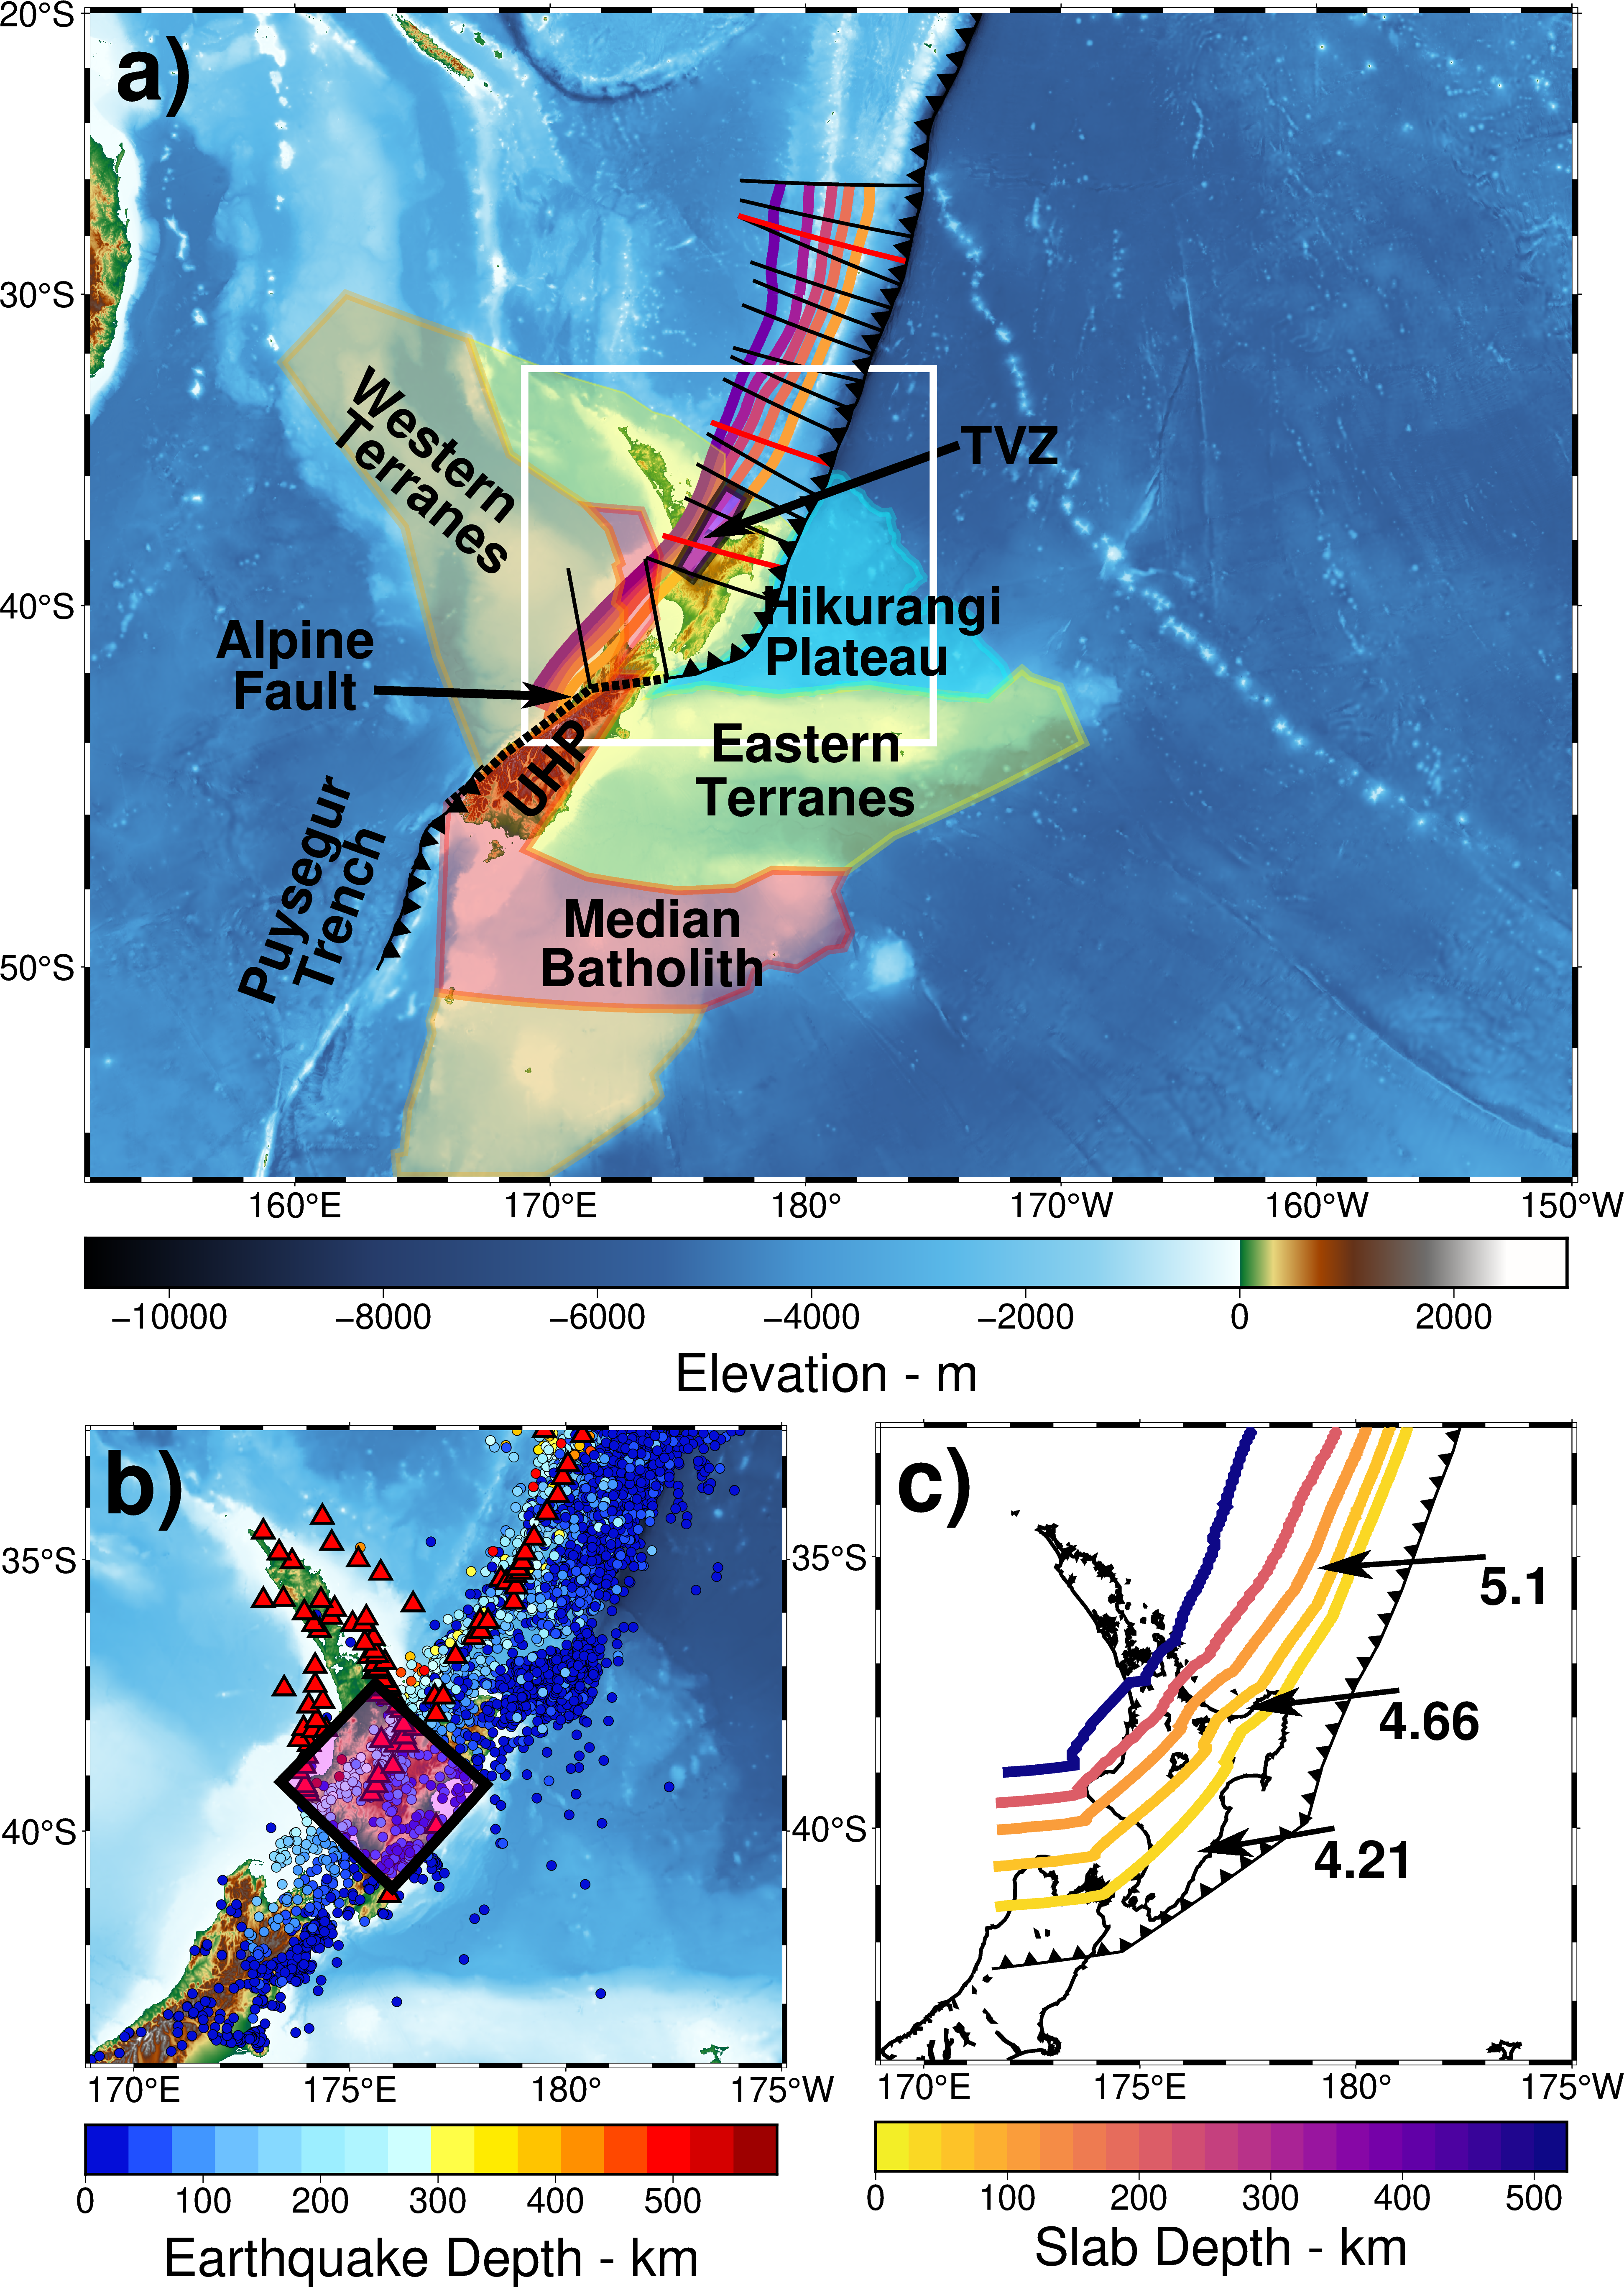

In [7]:
large_region = [152, 210, -55, -20]
small_region = [169, 185, -44, -32.5]

grid = pygmt.datasets.load_earth_relief(resolution="01m", region=large_region)
fig = pygmt.Figure()
pygmt.config(FONT_LABEL='30p', MAP_LABEL_OFFSET='0.5', MAP_TICK_PEN_PRIMARY=None, FONT_ANNOT_PRIMARY='20p')
rectangle = [[small_region[0], small_region[2], small_region[1], small_region[3]]]

fig.basemap(region=large_region, projection="M30c", frame=["af"])
fig.grdimage(grid=grid, cmap="geo")

fig.colorbar(position="JBC+o-0.1c/1.25c+w30c/1c+h", frame=["a2000", "x+lElevation - m"])

# Vector specifications structured as: [x_start, y_start, direction_degrees, length]
vector_1 = [-177, -35, 90 + 93.9, 5.106 / 1.5]
vector_2 = [-179, -37.5, 90 + 96.8, 4.66 / 1.5]
vector_3 = [179.5, -40, 90 + 99.7, 4.21 / 1.5]

# Create a list of lists that include each vector information
vectors = [vector_1, vector_2, vector_3]

pygmt.makecpt(cmap="plasma", series=[0, 700, 100], color_model="+c0-9", reverse=True)

slab2_depth_contour_vals = -np.arange(0, 600, 100)
for value in slab2_depth_contour_vals:
    if value != 0:
        lat_cutoff_indices = np.where(slab2_contours[:, 1] <= -26.15)
        slab2_cont_indices = np.where(slab2_contours[:, 2][lat_cutoff_indices] == value)
        fig.plot(x=slab2_contours[:, 0][lat_cutoff_indices][slab2_cont_indices], \
                 y=slab2_contours[:, 1][lat_cutoff_indices][slab2_cont_indices], \
                 pen="6p,black", zvalue=np.abs(value), cmap=True)

other_vals = -np.arange(400, 600, 100)
for value in other_vals:
    slab2_cont_indices = np.where( (-supplemental_file[:, 2] <= value + 0.52) & (-supplemental_file[:, 2] >= value - 0.52) )
    fig.plot(x=supplemental_file[:, 0][slab2_cont_indices], y=supplemental_file[:, 1][slab2_cont_indices], pen="6p,black", zvalue=np.abs(value), cmap=True)

region_transparency = 70
fig.plot(x=AUS_eastprov[:, 0], y=AUS_eastprov[:, 1], pen="1p,yellow", fill="yellow", transparency=region_transparency)
fig.plot(x=PAC_eastprov[:, 0], y=PAC_eastprov[:, 1], pen="5p,yellow", fill="yellow", transparency=region_transparency)

fig.plot(x=AUS_MB[:, 0], y=AUS_MB[:, 1], pen="5p,red", fill="red", transparency=region_transparency)
fig.plot(x=PAC_MB[:, 0], y=PAC_MB[:, 1], pen="5p,red", fill="red", transparency=region_transparency)

fig.plot(x=AUS_westprov[:, 0], y=AUS_westprov[:, 1], pen="5p,orange", fill="orange", transparency=region_transparency)
fig.plot(x=PAC_westprov[:, 0], y=PAC_westprov[:, 1], pen="5p,orange", fill="orange", transparency=region_transparency)

fig.plot(x=AUS_TVZ[:, 0], y=AUS_TVZ[:, 1], pen="5p,black", fill="purple", transparency=region_transparency - 35)
fig.plot(x=HIK_plateau[:, 0], y=HIK_plateau[:, 1], pen="5p,cyan", fill="cyan", transparency=region_transparency)

fig.plot(
    region=large_region,
    data=[[186, -35, 200, 5.5]],
    style="v1.0c+e",
    pen="5p,black",
    fill="black"
)

profile_number = 0
for file in np.sort(os.listdir(profile_directory)):
    profile_file = np.loadtxt(fname=profile_directory + file)
    if profile_number == 3 or profile_number == 7 or profile_number == 15:
        fig.plot(x=profile_file[:, 0], y=profile_file[:, 1], pen="3p,red")
    else:
        fig.plot(x=profile_file[:, 0], y=profile_file[:, 1], pen="2p,black")
    profile_number += 1

fig.plot(data=rectangle, style="r+s", pen="4p,white", straight_line=True)

fig.text(x=154.5, y=-22, text="a)", angle=0, font="50p,Helvetica-Bold,black")

fig.text(x=165.5, y=-35, text="Western", angle=-40, font="30p,Helvetica-Bold,black")
fig.text(x=165, y=-36.5, text="Terranes", angle=-40, font="30p,Helvetica-Bold,black")
fig.text(x=174, y=-48.75, text="Median", angle=0, font="30p,Helvetica-Bold,black")
fig.text(x=174, y=-50., text="Batholith", angle=0, font="30p,Helvetica-Bold,black")
fig.text(x=180, y=-44, text="Eastern", angle=0, font="30p,Helvetica-Bold,black")
fig.text(x=180, y=-45.5, text="Terranes", angle=0, font="30p,Helvetica-Bold,black")
fig.text(x=183, y=-40, text="Hikurangi", angle=0, font="30p,Helvetica-Bold,black")
fig.text(x=182, y=-41.5, text="Plateau", angle=0, font="30p,Helvetica-Bold,black")
fig.text(x=188, y=-35, text="TVZ", angle=0, font="30p,Helvetica-Bold,black")
fig.text(x=170, y=-44.75, text="UHP", angle=50, font="30p,Helvetica-Bold,black")
fig.text(x=160, y=-41, text="Alpine", angle=0, font="30p,Helvetica-Bold,black")
fig.text(x=160, y=-42.5, text="Fault", angle=0, font="30p,Helvetica-Bold,black")
fig.text(x=160, y=-48, text="Puysegur", angle=70, font="30p,Helvetica-Bold,black")
fig.text(x=161.75, y=-48.5, text="Trench", angle=70, font="30p,Helvetica-Bold,black")

fig.plot(x=Alpine_Fault[:, 0], y=Alpine_Fault[:, 1], pen="5p,black,4_2:2p")

fig.plot(x=trench[:, 0], y=trench[:, 1], pen="1.5p", style="f0.5c/0.4c+l+t+o0.5c+p", fill='black')
fig.plot(x=puysegur_trench[:, 0], y=puysegur_trench[:, 1], pen="1.5p", style="f0.5c/0.4c+l+t+o0.5c+p", fill='black')

fig.plot(
    region=large_region,
    data=[[163.1, -42.5, -2, 4]],
    style="v1.0c+e",
    pen="5p,black",
    fill="black"
)

fig.shift_origin(xshift="w-30c", yshift="h-41.5c")

fig.basemap(region=small_region, projection="M14c", frame=["af"])
fig.grdimage(grid=grid, cmap="geo")

pygmt.makecpt(cmap="panoply", series=[earthquakes[:, 2].min(), earthquakes[:, 2].max()])
fig.plot(
    x=earthquakes[:, 1],
    y=earthquakes[:, 0],
    size=0.2 + earthquakes[:, 3]*0,
    fill=earthquakes[:, 2],
    cmap=True,
    style="cc",
    pen="black",
)

fig.colorbar(position="JBC+o-0.1c/1.25c+w14c/1c+h", frame=["a100", "x+lEarthquake Depth - km"])

fig.plot(
    x=volcanoes[:, 0],
    y=volcanoes[:, 1],
    fill='red',
    size=0.5 + volcanoes[:, 0]*0,
    style='t',
    pen='1.5p,black',
)

fig.text(x=170.25, y=-33.5, text="b)", angle=0, font="50p,Helvetica-Bold,black")

fig.plot(x=min_max_LPO_lon, y=min_max_LPO_lat, pen="1p,black", fill="magenta", transparency=region_transparency)
fig.plot(x=min_max_LPO_lon, y=min_max_LPO_lat, pen="6p,black")

fig.shift_origin(xshift="w2c", yshift="h-12.75c")
fig.basemap(region=small_region, projection="M14c", frame=["af"])
fig.coast(shorelines="2p,black")

pygmt.makecpt(cmap="plasma", series=[0, 500, 25], color_model="+c0-9", reverse=True)

for i in range(len(depth_contour_vals)):
    fig.plot(x=model_depth_contour_lons[i], \
             y=model_depth_contour_lats[i], \
             pen="6p,black", zvalue=np.abs(depth_contour_vals[i]), cmap=True)

fig.plot(x=ASPECT_trench_lon, y=ASPECT_trench_lat, pen="1.5p", style="f0.5c/0.3c+l+t+o0.3c+p", fill='black')
fig.colorbar(position="JBC+o-0.1c/1.25c+w14c/1c+h", frame=["a100", "x+lSlab Depth - km"])

fig.plot(
    region=small_region,
    data=vectors,
    style="v1.1c+e",
    pen="3p,black",
    fill="black",
)

fig.text(x=170.25, y=-33.5, text="c)", angle=0, font="50p,Helvetica-Bold,black")

fig.text(x=vector_1[0] + 0.7, y=vector_1[1] - 0.55, text=str(5.10), font="30p,Helvetica-Bold,black")
fig.text(x=vector_2[0] + 0.7, y=vector_2[1] - 0.55, text=str(4.66), font="30p,Helvetica-Bold,black")
fig.text(x=vector_3[0] + 0.7, y=vector_3[1] - 0.55, text=str(4.21), font="30p,Helvetica-Bold,black")

fig.savefig("regional-map-figure.png", transparent=True)
fig.show()